# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [1]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [2]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент?

**Ответ:** PCA используется в алгоритме для снижения размерности исходных данных. Это позволяет уменьшить вычислительные затраты на последующие этапы, такие как оценка гиперпараметра $\sigma^2$, генерация новых признаков с помощью Random Fourier Features и обучение модели. PCA сохраняет основную информацию о данных, устраняя избыточные и коррелированные признаки, что может также способствовать улучшению обобщающей способности модели и снижению переобучения модели.

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [9]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)

In [12]:
import time

In [17]:
from sklearn.metrics import accuracy_score

start_time_train = time.time()
pipeline.fit(x_train, y_train)
train_time = time.time() - start_time_train
y_pred = pipeline.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Time for Random Fourier Features : {train_time:.6f}")

Accuracy: 0.8574
Time for Random Fourier Features : 63.398667


__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [18]:
from sklearn.svm import LinearSVC
import numpy as np
subset_size = 1000
subset_idx = np.random.choice(x_train.shape[0], subset_size, replace=False)
x_train_subset, y_train_subset = x_train[subset_idx], y_train[subset_idx]

linear_svm = LinearSVC()
start_time_train_linear_svm = time.time()
linear_svm.fit(x_train_subset, y_train_subset)
train_time_linear_svm = time.time() - start_time_train_linear_svm
y_pred_linear_svm = linear_svm.predict(x_test)

accuracy_liniar_svm = accuracy_score(y_test, y_pred_linear_svm)
print(f"Accuracy for Linear SVM: {accuracy_liniar_svm:.4f}")
print(f"Time for Linear SVM Random Fourier Features: {train_time_linear_svm:.6f}")

Accuracy for Linear SVM: 0.7606
Time for Linear SVM Random Fourier Features: 0.521150


In [19]:
from sklearn.svm import SVC

kernel_svm = SVC(kernel='rbf')
start_time_train_kernel_svm = time.time()
kernel_svm.fit(x_train_subset, y_train_subset)
train_time_kernel_svm = time.time() - start_time_train_kernel_svm
y_pred_kernel_svm = kernel_svm.predict(x_test)

accuracy_kernel_svm = accuracy_score(y_test, y_pred_kernel_svm)
print(f"Accuracy for Kernel SVM: {accuracy_kernel_svm:.4f}")
print(f"Time for Kernel SVM Random Fourier Features: {train_time_kernel_svm:.6f}")

Accuracy for Kernel SVM: 0.7915
Time for Kernel SVM Random Fourier Features: 0.753179


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
start_time_train_lgbm = time.time()
lgbm.fit(x_train_pca, y_train)
train_time_lgbm = time.time() - start_time_train_lgbm
y_pred_pca_lgbm = lgbm.predict(x_test_pca)

accuracy_pca_lgbm = accuracy_score(y_test, y_pred_pca_lgbm)
print(f"PCA + LightGBM Accuracy: {accuracy_pca_lgbm:.4f}")
print(f"Time for LightGBM : {train_time_lgbm:.6f} seconds")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 50
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
PCA + LightGBM Accuracy: 0.8661
Time for LightGBM : 51.361381 seconds


Мы сравнили между собой четыре метода: Linear SVM, Kernel SVM, Random Fourier Features и подход с понижением размерности с помощью PCA, за которым следует обучение градиентного бустинга.

Если говорить об обычном SVM, то ядровой SVM показал более высокое качество по сравнению с линейным. Это ожидаемо, так как ядровой метод лучше отражает сложные нелинейные зависимости в данных. Однако стоит отметить, что обучение ядрового SVM заняло значительно больше времени, чем линейного (хотя длительное время обучения — это характерная особенность всего семейства SVM, особенно при использовании ядровых методов).

Метод Random Fourier Features продемонстрировал качество лучше, чем линейный и даже ядровой SVM, что показывает его потенциал для аппроксимации нелинейных зависимостей с меньшими затратами. Однако время обучения RFF оказалось выше, чем у линейного SVM, и даже ядрового.

Затем мы сравнили SVM и подход с понижением размерности с помощью PCA, за которым следовало обучение градиентного бустинга. Градиентный бустинг продемонстрировал значительно более высокое качество, чем SVM, что объясняется его способностью эффективно выявлять сложные зависимости в данных. Однако это потребовало большего времени на обучение по сравнению как с линейным, так и с ядровым SVM.

Если говорить о сравнении градиентного бустинга и Random Fourier Features, то градиентный бустинг показал качество на одну десятую выше, чем RFF. Тем не менее, время обучения градиентного бустинга оказалось чуть большим, чем у RFF.



__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [9]:
pipeline_no_pca = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA=False)
pipeline_no_pca.fit(x_train, y_train)
y_pred_no_pca = pipeline_no_pca.predict(x_test)
accracy_no_pca = accuracy_score(y_test, y_pred_no_pca)


print(f"Accuracy without PCA: {accracy_no_pca :.4f}")
print(f"Accuracy with PCA: {accuracy:.4f}")

Accuracy without PCA: 0.1104
Accuracy with PCA: 0.8590


1. Предварительное понижение размерности кардинально повысило качество модели (в 8 раз). Это происходит потому, что PCA удаляет шум в данных и устраняет мультиколлинеарность между признаками. Шумовые признаки часто не содержат полезной информации, но могут сбивать модель, особенно если их много. Устраняя их, PCA позволяет сосредоточиться на наиболее значимых признаках. Кроме того, уменьшение размерности помогает модели лучше обобщать данные и снижает риск переобучения, так как модель меньше подстраивается под избыточные или неинформативные признаки.

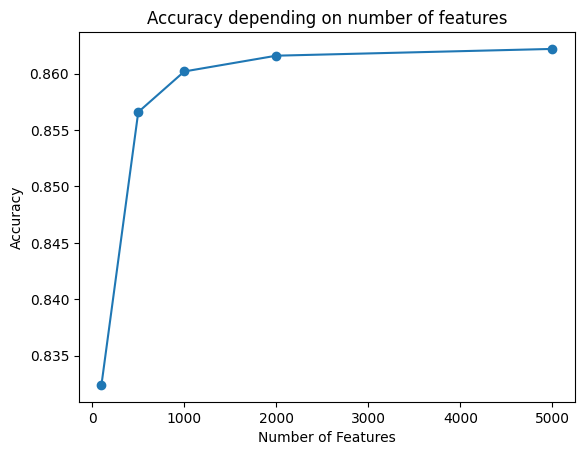

In [10]:
import matplotlib.pyplot as plt

n_features_list = [100, 500, 1000, 2000, 5000]
accuracies = []

for n in n_features_list:
    pipeline = RFFPipeline(n_features=n, new_dim=50, feature_creator_class=RandomFeatureCreator)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.plot(n_features_list, accuracies, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Accuracy depending on number of features")
plt.show()

2. Чем больше случайных признаков (RFF), тем выше качество модели. Однако после достижения порога в 2000 признаков наблюдается плато, и дальнейшее увеличение количества признаков практически не улучшает качество. Это связано с тем, что при достаточном числе признаков ядро становится достаточно хорошо аппроксимированным, и дальнейшее увеличение числа признаков только добавляет вычислительные затраты без значительного прироста точности.

In [5]:
import numpy as np
subset_size = 1000
subset_idx = np.random.choice(x_train.shape[0], subset_size, replace=False)
x_train_subset, y_train_subset = x_train[subset_idx], y_train[subset_idx]

In [10]:
pipeline_svm = RFFPipeline(n_features=1000, use_PCA=True, classifier_class=SVC, classifier_params={"kernel": "linear"})
pipeline_svm.fit(x_train_subset, y_train_subset)
y_pred_svm = pipeline_svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy with SVM: {accuracy_svm:.4f}")

Accuracy with SVM: 0.7560


3. В данном эксперименте логистическая регрессия показала лучшее качество, чем линейный SVM, с разницей примерно в одну десятую долю. Более того, логистическая регрессия обучалась значительно быстрее, чем SVM, что делает ее предпочтительным выбором для данной задачи.

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.


In [32]:
from homework_practice_08_rff import OrthogonalRandomFeatureCreator

pipeline_orth = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)

In [14]:
start_time_train_orth = time.time()
pipeline_orth.fit(x_train, y_train)
train_time_orth = time.time() - start_time_train_orth
y_pred_orth = pipeline_orth.predict(x_test)

accuracy_orth = accuracy_score(y_test, y_pred_orth)
print(f"Accuracy for Orthogonal Random Features: {accuracy_orth:.4f}")
print(f"Time for Orthogonal Random Features: {train_time_orth:.6f}")

Accuracy for Orthogonal Random Features: 0.8611
Time for Orthogonal Random Features: 63.717056


Мы провели сравнение Random Fourier Features и Orthogonal Random Features с точки зрения качества модели и скорости обучения. В ходе экспериментов было выявлено, что ORF демонстрируют более высокое качество, чем RFF. Это объясняется тем, что признаки, сгенерированные с помощью ORF, ортогональны, что снижает избыточность и корреляцию между ними. Меньшая корреляция позволяет модели эффективнее использовать признаки и лучше улавливать зависимости в данных.

Кроме того, обучение моделей на ORF оказалось быстрее, чем на RFF. Ортогонализация признаков снижает сложность численных вычислений и улучшает стабильность оптимизации, что приводит к более быстрой сходимости модели. Это преимущество особенно заметно при использовании линейных методов, которые чувствительны к взаимной зависимости признаков.

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу___: https://vikas.sindhwani.org/RandomLaplace.pdf


___описание идеи:___ авторы предлагают метод Random Laplace Features для аппроксимации семигрупповых ядер (semigroup kernel), применимых к гистограммам и другим неотрицательным данным. В отличие от Random Fourier Features, которые используют преобразование Фурье для создания сдвиг-инвариантных признаков, данный метод основывается на преобразовании Лапласа. Это позволяет эффективно аппроксимировать ядра, учитывающие аддитивную структуру неотрицательных данных, что особенно полезно в задачах компьютерного зрения и анализа гистограмм.

In [33]:
from homework_practice_08_rff import RandomLaplaceFeatureCreator

pipeline_lap = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, feature_creator_class=RandomLaplaceFeatureCreator)

In [34]:
start_time_train_lap = time.time()
pipeline_lap.fit(x_train, y_train)
train_time_lap = time.time() - start_time_train_lap
y_pred_lap = pipeline_lap.predict(x_test)

accuracy_lap = accuracy_score(y_test, y_pred_lap)
print(f"Accuracy for Random Laplace Features: {accuracy_lap:.4f}")
print(f"Time for Random Laplace Features: {train_time_lap:.6f}")

Accuracy for Random Laplace Features: 0.1000
Time for Random Laplace Features: 6.315945


Точность метода Random Laplace Features оказалась в 8 раз ниже, чем у Random Fourier Features. RLF используют экспоненциальное распределение случайных весов, в отличие от гауссового в RFF. Это может приводить к менее равномерному покрытию пространства признаков, особенно если данные распределены неэкспоненциально, что ухудшает способность модели приближать сложные зависимости. Я бы также отметила, что ядро Лапласа менее гибкое, чем гауссовое, используемое в RFF. Гауссовые ядра хорошо аппроксимируют широкий спектр зависимостей, тогда как ядро Лапласа более ограничено в своей форме, что может объяснять сильное падение точности.

При этом RLF обучается быстрее, поскольку его вычисления требуют меньше ресурсов.

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**.
Подумайте о том, как в формулах правильно учесть свободный коэффициент.

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___
$$
Q(w) = \frac{1}{2} ||Kw - y||^2 + \frac{\lambda}{2} w^T K w \rightarrow \min_w,
$$
$$
\nabla Q(w) = K(Kw-y) + \lambda K W
$$
$$
\nabla Q(w) = K K w - K y + \lambda K w
$$
$$
\nabla Q(w) = K(Kw - y - \lambda w)
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [1]:
from homework_practice_08_kernel_regression import KernelRidgeRegression

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
X = np.linspace(-2, 2, 1000).reshape(-1, 1)
y = np.sin(3 * X).ravel() + 0.1 * np.random.randn(1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_krr = KernelRidgeRegression()

start_time = time.time()
model_krr.fit_closed_form(X_train, y_train)
time_krr = time.time() - start_time

y_pred_krr = model_krr.predict(X_test)

mse_krr = mean_squared_error(y_test, y_pred_krr)

print(f"MSE for Kernel Ridge Regression: {mse_krr:.4f}")
print(f"Time for Kernel Ridge Regression: {time_krr:.6f}")

MSE for Kernel Ridge Regression: 0.0319
Time for Kernel Ridge Regression: 0.074369


In [18]:
from sklearn.svm import SVR

In [19]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier_class= SVR, feature_creator_class=RandomFeatureCreator)

In [20]:
start_time_train = time.time()
pipeline.fit(X_train, y_train)
train_time = time.time() - start_time_train
y_pred = pipeline.predict(X_test)

mse_rff = mean_squared_error(y_test, y_pred)

print(f"MSE for Random Fourier Features: {mse_rff:.4f}")
print(f"Time for Random Fourier Features : {train_time:.6f}")

MSE for Random Fourier Features: 0.0104
Time for Random Fourier Features : 0.757751


RFF показал меньшую ошибку, что подтверждает его способность приближать сложные зависимости. Однако KRR обучался быстрее, так как использует аналитическое решение, тогда как RFF требует генерации случайных признаков и обучения линейной модели.

На небольших выборках KRR может быть более выгодным из-за скорости, но при увеличении объема данных вычислительная сложность KRR возрастает, и RFF становится предпочтительнее. В целом, RFF демонстрирует хорошее качество и является конкурентоспособной альтернативой ядровым методам в регрессии.